In [1]:
import os
import pandas as pd
import glob
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
import pdb
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sns
from pylab import plot, show, savefig, xlim, figure, ylim, legend, boxplot, setp, axes #hold



In [2]:
####################################################
## import the experimental values
# set paths
repobasedir = os.getcwd()
experimentalfile = os.path.join(repobasedir, 'experimentalMetabolics_all.csv')
# read in the file to dataframe
expmetcost_df = pd.read_csv(experimentalfile)
print(expmetcost_df)
# print(expmetcost)
# f, ax = plt.subplots()
# expmetcost.plot(x="experiment [pi]",y="cost [W/kg]",title="plot of all exp costs",ax=ax)
# expmetcost_df.plot(y="metabolics_all_avg",title="plot of all exp costs",ax=ax, marker='o', alpha=0.7)
# plt.show()
# import pdb
# pdb.set_trace()



     metabolics_all_avg subjectname     condname experimentname trialname
0              5.067015     wals024    walsslack          walsh   trial01
1              4.214548     wals077    walsslack          walsh   trial01
2              4.290595     wals088    walsslack          walsh   trial01
3              5.698502     wals112    walsslack          walsh   trial01
4              4.382331     wals127    walsslack          walsh   trial01
..                  ...         ...          ...            ...       ...
662           10.361830     sild035  sild10wrun0         silder   trial01
663            2.904840     sild035     sild20w0         silder   trial01
664           11.630630     sild035  sild20wrun0         silder   trial01
665            3.954340     sild035     sild30w0         silder   trial01
666           12.044730     sild035  sild30wrun0         silder   trial01

[667 rows x 5 columns]


In [3]:
## import all of the simulation results
# set all the paths
simresultspath = os.path.join(repobasedir,'..\\metabolicsResults\\')
muscleinversepath = os.path.join(simresultspath,'muscleInverse\\')
muscleInverseWithEMGpath = os.path.join(simresultspath,'muscleInverseWithEMG\\')

## first handle the values in the regular muscle driven inverse problem
# get all the filenames
musclefiles = glob.glob(os.path.join(muscleinversepath,'*.csv'))
# load them all into a single dataframe
df_from_each_file = (pd.read_csv(f) for f in musclefiles)
# print(df_from_each_file)
muscle_df = pd.concat(df_from_each_file, ignore_index=True)
muscle_df

,Row,metabolics_all_avg,metabolics_act_avg,metabolics_short_avg,metabolics_basal_avg,metabolics_mech_avg,metabolics_gas_avg,metabolics_sol_avg,metabolics_bifemlh_avg,metabolics_recfem_avg,metabolics_swing_avg,metabolics_stance_avg,model_mass,subjectname,condname,experimentname,trialname
0,trial,10.400014,5.306119,7.105892,1.2,-3.211997,-3.821133e-01,7.595851e-01,1.356199e+00,1.145618e+00,2.670731,7.464392,66.80,welk002,welknatural,welk,trial01
1,trial,11.226170,5.587081,6.625586,1.2,-2.186496,NaN,NaN,NaN,NaN,3.102622,7.623666,66.80,welk002,welknatural,welk,trial02
2,trial,10.226703,5.070600,5.700827,1.2,-1.744724,7.505338e+250,1.849405e+251,NaN,2.852309e+72,2.656206,6.917954,66.80,welk002,welknatural,welk,trial03
3,trial,10.292716,5.060787,6.374330,1.2,-2.342401,2.395395e-311,0.000000e+00,8.127829e-312,7.752699e-312,2.774289,6.863222,66.80,welk002,welknatural,welk,trial04
4,trial,10.006568,5.005966,5.095338,1.2,-1.294735,2.033670e+00,3.651861e+00,-2.058417e+00,1.211276e+00,2.822486,6.637611,66.80,welk002,welkexo,welk,trial01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,trial,12.066358,5.632989,6.679319,1.2,-1.445949,7.310688e+00,1.886406e+01,1.110017e+01,3.486413e+00,3.766419,8.663653,57.61,welk013,welknatural,welk,trial04
60,trial,10.296686,4.868677,5.099590,1.2,-0.871580,2.844820e+00,5.347351e+00,3.445132e+00,1.369877e+00,3.489604,6.138143,57.61,welk013,welkexo,welk,trial01
61,trial,10.624772,4.912019,5.372281,1.2,-0.859528,2.452370e+00,1.002858e+01,1.271697e+00,3.435773e-01,3.518947,6.706790,57.61,welk013,welkexo,welk,trial02
62,trial,10.236551,4.846890,6.036891,1.2,-1.847230,1.184684e+00,3.386374e-01,1.161625e+01,5.067943e+00,3.408706,6.384588,57.61,welk013,welkexo,welk,trial03


In [4]:

# get the full metabolics dataframe
# test_df = muscle_df.groupby(['subjectname','condname','trialname']).agg({'metabolics_all_avg':['mean']})
test_df = muscle_df.groupby(['subjectname','condname']).agg({'metabolics_all_avg':['mean']})
test_df.columns = ['metabolics_all_avg_mean']
test_df = test_df.reset_index()
print('test_df: full metabolics df')
print(test_df)

# get the swing metabolics dataframe
# swing_df = muscle_df.groupby(['subjectname','condname','trialname']).agg({'metabolics_swing_avg':['mean']})
swing_df = muscle_df.groupby(['subjectname','condname']).agg({'metabolics_swing_avg':['mean']})
swing_df.columns = ['metabolics_swing_avg_mean']
swing_df = swing_df.reset_index()
print('swing_df')
print(swing_df)
# get the stance metabolics dataframe
# stance_df = muscle_df.groupby(['subjectname','condname','trialname']).agg({'metabolics_stance_avg':['mean']})
stance_df = muscle_df.groupby(['subjectname','condname']).agg({'metabolics_stance_avg':['mean']})
stance_df.columns = ['metabolics_stance_avg_mean']
stance_df = stance_df.reset_index()
print('stance_df')
print(stance_df)


test_df: full metabolics df
   subjectname     condname  metabolics_all_avg_mean
0      welk002      welkexo                 9.786012
1      welk002  welknatural                10.536401
2      welk003      welkexo                10.720083
3      welk003  welknatural                11.088915
4      welk005      welkexo                 9.834362
5      welk005  welknatural                12.667467
6      welk007      welkexo                11.509396
7      welk007  welknatural                11.161131
8      welk008      welkexo                 9.144444
9      welk008  welknatural                 9.963972
10     welk009      welkexo                10.167945
11     welk009  welknatural                11.200958
12     welk010      welkexo                10.611722
13     welk010  welknatural                10.983644
14     welk013      welkexo                10.394561
15     welk013  welknatural                12.341575
swing_df
   subjectname     condname  metabolics_swing_avg_mean
0      

In [5]:

# get the experimental metabolics dataset in the same form - averaged across subject conditions and trials. 

# exp_df = expmetcost_df.groupby(['subjectname','condname','trialname']).agg({'metabolics_all_avg':['mean']})
# exp_df.columns = ['metabolics_all_avg_mean']
# exp_df = exp_df.reset_index()
# print('exp_df')
# print(exp_df)

# try to average across the gait cycles. 
exp_df2 = expmetcost_df.groupby(['subjectname','condname']).agg({'metabolics_all_avg':['mean']})
exp_df2.columns = ['metabolics_all_avg_mean']
exp_df2 = exp_df2.reset_index()
exp_df = exp_df2
print('exp_df')
print(exp_df)

exp_df
    subjectname           condname  metabolics_all_avg_mean
0       demb005     dembloadedfree                 6.040289
1       demb005  dembloadedmatched                 6.281147
2       demb005     dembnoloadfree                 4.682754
3       demb005     dembnoloadslow                 4.152233
4       demb007     dembloadedfree                 6.282373
..          ...                ...                      ...
472     welk010        welknatural                12.297055
473     welk011            welkexo                 9.901415
474     welk011        welknatural                 8.467083
475     welk013            welkexo                10.117616
476     welk013        welknatural                10.937716

[477 rows x 3 columns]


In [6]:

# trials included
# both_df = pd.merge(test_df, exp_df, how='right', on=['subjectname','condname','trialname'])
# averaged on trials too
both_df = pd.merge(test_df, exp_df, how='right', on=['subjectname','condname'])
pd.set_option('display.max_rows',None) #,'display.max_columns',None)

bothtrim_df = both_df.dropna()
print(bothtrim_df)

    subjectname     condname  metabolics_all_avg_mean_x  \
439     welk002      welkexo                   9.786012   
443     welk002  welknatural                  10.536401   
447     welk003      welkexo                  10.720083   
451     welk003  welknatural                  11.088915   
463     welk005      welkexo                   9.834362   
464     welk005  welknatural                  12.667467   
465     welk007      welkexo                  11.509396   
466     welk007  welknatural                  11.161131   
467     welk008      welkexo                   9.144444   
468     welk008  welknatural                   9.963972   
469     welk009      welkexo                  10.167945   
470     welk009  welknatural                  11.200958   
471     welk010      welkexo                  10.611722   
472     welk010  welknatural                  10.983644   
475     welk013      welkexo                  10.394561   
476     welk013  welknatural                  12.341575 

In [25]:
### going to make a print out of the actual reductions for swing and stance, as well as percent 
# grab the raw differences between them
stance_means = stance_df.groupby(['condname']).agg({'metabolics_stance_avg_mean':['mean']})
swing_means = swing_df.groupby(['condname']).agg({'metabolics_swing_avg_mean':['mean']})

print(stance_means)
print(swing_means)

# get all the values in a workable format
swings_exo = swing_df.loc[swing_df['condname'] == 'welkexo']
swings_natural = swing_df.loc[swing_df['condname'] == 'welknatural']
stances_exo = stance_df.loc[stance_df['condname'] == 'welkexo']
stances_natural = stance_df.loc[stance_df['condname'] == 'welknatural']

# get the average raw differences for both stance and swing - check with above
stance_change = np.mean(stances_exo) - np.mean(stances_natural)
swing_change = np.mean(swings_exo) - np.mean(swings_natural)
# now to get the percent changes for stance and swing
stance_perc_change = (np.mean(stances_exo) - np.mean(stances_natural)) / (np.sum([np.mean(stances_natural), np.mean(swings_natural)]) * 100)
swing_perc_change = (np.mean(swings_exo) - np.mean(swings_natural)) / (np.sum([np.mean(stances_natural), np.mean(swings_natural)]) * 100)

# stance_perc_change


print("Raw stance difference: %f" % stance_change)
print('Raw swing  difference: %f' % swing_change)
print('Percent Difference stance: %f' % stance_perc_change)
print('Percent Difference swing: %f' % swing_perc_change)



            metabolics_stance_avg_mean
                                  mean
condname                              
welkexo                       6.579713
welknatural                   7.620405
            metabolics_swing_avg_mean
                                 mean
condname                             
welkexo                      3.114491
welknatural                  3.395791
Raw stance difference: -1.040693
Raw swing  difference: -0.281300
Percent Difference stance: -0.000945
Percent Difference swing: -0.000255


In [26]:
print(np.sum([np.mean(stances_natural), np.mean(swings_natural)]))
print((np.mean(stances_exo) - np.mean(stances_natural)))


swings_natural

11.016196063787095
metabolics_stance_avg_mean   -1.040693
dtype: float64


,subjectname,condname,metabolics_swing_avg_mean
1,welk002,welknatural,2.800962
3,welk003,welknatural,3.168818
5,welk005,welknatural,4.729537
7,welk007,welknatural,3.342967
9,welk008,welknatural,2.839167
11,welk009,welknatural,3.521559
13,welk010,welknatural,2.986284
15,welk013,welknatural,3.777032


In [9]:
swings_exo

,subjectname,condname,metabolics_swing_avg_mean
0,welk002,welkexo,2.749610
2,welk003,welkexo,3.268384
4,welk005,welkexo,3.261615
6,welk007,welkexo,3.372191
8,welk008,welkexo,2.626296
10,welk009,welkexo,3.198323
12,welk010,welkexo,2.966138
14,welk013,welkexo,3.473374


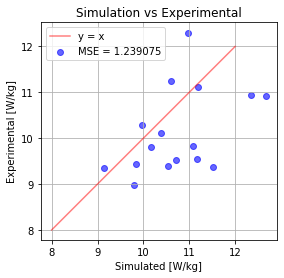

In [10]:

# make a figure for the simulations vs exp
f, ax = plt.subplots()
tempx = bothtrim_df['metabolics_all_avg_mean_x']
tempy = bothtrim_df['metabolics_all_avg_mean_y']
mse = mean_squared_error(tempy, tempx)
ax.scatter(tempx, tempy, marker='o', alpha=0.6, c='blue', label='MSE = %f'%mse)
# line = mlines.Line2D([0,1], [0,1], color='red')
# transform = ax.transAxes
# line.set_transform(transform)
# ax.add_line(line)
unitx = np.linspace(8,12,100)
ax.plot(unitx,unitx,color='red',alpha=0.5, label='y = x')
# some nice 
ax.set_title('Simulation vs Experimental')
# plt.xlim([8, 13])
# plt.ylim([8, 13])
ax.set_aspect('equal', adjustable='box')
plt.grid()
plt.xlabel('Simulated [W/kg]')
plt.ylabel('Experimental [W/kg]')
plt.legend()
# plt.show()

In [11]:
# make a figure for exo vs natural stance and swing
# thinking box plots
# pdb.set_trace()

swingexo = np.array([])
swingnatural = np.array([])
stanceexo = np.array([])
stancenatural = np.array([])

# split the swings up
for i, row in swing_df.iterrows():
    # print(i)
    # print(row)
    tempcond = row['condname']
    if 'welkexo' in tempcond:
        swingexo = np.append(swingexo, row['metabolics_swing_avg_mean'])
    elif 'welknatural' in tempcond:
        swingnatural = np.append(swingnatural, row['metabolics_swing_avg_mean'])
for i, row in stance_df.iterrows():
    # print(i)
    # print(row)
    tempcond = row['condname']
    if 'welkexo' in tempcond:
        stanceexo = np.append(stanceexo, row['metabolics_stance_avg_mean'])
    elif 'welknatural' in tempcond:
        stancenatural = np.append(stancenatural, row['metabolics_stance_avg_mean'])


In [12]:
# function for setting the colors of the box plots pairs
def setBoxColors(bp):

    setp(bp['boxes'][1], color='blue')
    setp(bp['caps'][2], color='blue')
    setp(bp['caps'][3], color='blue')
    setp(bp['whiskers'][2], color='blue')
    setp(bp['whiskers'][3], color='blue')
    setp(bp['fliers'][0], color='blue')
    setp(bp['fliers'][1], color='blue')
    setp(bp['medians'][1], color='blue')

    setp(bp['boxes'][0], color='red')
    setp(bp['caps'][0], color='red')
    setp(bp['caps'][1], color='red')
    setp(bp['whiskers'][0], color='red')
    setp(bp['whiskers'][1], color='red')
    setp(bp['fliers'][0], color='red')
    setp(bp['fliers'][1], color='red')
    setp(bp['medians'][0], color='red')


!!! Need to change this to only get the one leg and not the double !!!

 We really are only showing the results of one leg


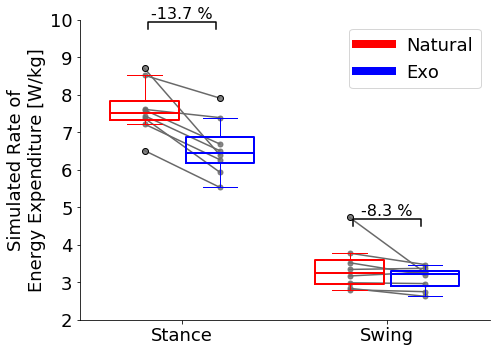

In [13]:
print("!!! Need to change this to only get the one leg and not the double !!!\n\n We really are only showing the results of one leg")

swings = [swingnatural, swingexo]
stances = [stancenatural, stanceexo]


# pdb.set_trace()
fig = figure(figsize=(7,5))
ax = axes()
#hold(True)

boxprops = dict(linewidth=2)
medianprops = dict(linewidth=2)
meanprops = dict(linewidth=2)
flierprops = dict(linewidth=2)


# first pair - stance
bp = boxplot(stances, positions=[0.95,2.05], widths=1, zorder=100, 
             boxprops=boxprops, 
             meanprops=meanprops, 
             medianprops=medianprops,
            flierprops=flierprops)
setBoxColors(bp)
# second pair - swing
bp = boxplot(swings, positions=[3.95,5.05], widths=1, zorder=105,
            boxprops=boxprops, 
             meanprops=meanprops, 
             medianprops=medianprops,
            flierprops=flierprops)
setBoxColors(bp)
# set axes limits and labels
xlim(0,6)
ylim(2,10)


ax.set_xticks([1.5, 4.5])
# ax.set_xticklabels(['Stance\n{}% Avg. Difference', 'Swing\n{}% Avg. Difference'.format(stance_perc_change,swing_perc_change)],fontsize=24)
ax.set_xticklabels(['Stance', 'Swing'],fontsize=18)
# ax.yticks(fontsize=24)
# draw temporary red and blue lines and use them to create a legend
hB, = plot([1,1],'r-', lw=8)
hR, = plot([1,1],'b-', lw=8)
plt.legend((hB, hR),('Natural', 'Exo'),fontsize=18)
plt.ylabel('Simulated Rate of\nEnergy Expenditure [W/kg]',fontsize=18)
plt.yticks(fontsize=18)
hB.set_visible(False)
hR.set_visible(False)
# plt.grid()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

colorsjit = ['red', 'blue']
for i in [1,2]: # ,4,5]:
    y = stances[i-1] # titanic.age[titanic.pclass==i].dropna()
    # Add some random "jitter" to the x-axis
    # x = np.random.normal(i, 0.0, size=len(y))
    x = [.95*np.ones(len(y)), 2.05*np.ones(len(y))]
    plot(x[i-1], y, '.', alpha=0.8, color='dimgrey', zorder=4, markersize=10) # color=colorsjit[i-1])
for i in [4,5]:
    y = swings[i-4]
    # x = np.random.normal(i, 0.0, size=len(y))
    # need a different x value
    x = [3.95*np.ones(len(y)), 5.05*np.ones(len(y))]
    plot(x[i-4], y, '.', alpha=0.8, color='dimgrey', zorder=3, markersize=10) # color=colorsjit[i-4])

# figure out subject lines across conditions
x_stances = [0.95*np.ones(len(stances[0])), 2.05*np.ones(len(stances[1]))]
x_swings = [3.95*np.ones(len(stances[0])), 5.05*np.ones(len(stances[1]))]

plot(x_stances, stances, color='dimgrey', zorder=1)
plot(x_swings, swings, color='dimgrey', zorder=2)

# now figure out the bracket
x1, x2 = 1,2
y, h, col =  9.75, 0.2, 'black'
plt.plot([x1,x1,x2,x2], [y, y+h, y+h, y], color=col)
plt.text((x1+x2)*.5, y+h, '%.1f %%'%stance_perc_change, ha='center', va='bottom', color=col,
        fontsize=16)

x3, x4 = 4,5
y2, h2, col2 = 4.5, 0.2, 'black'
plt.plot([x3,x3,x4,x4], [y2, y2+h2, y2+h2, y2], color=col2)
plt.text((x3+x4)*.5, y2+h2, '%.1f %%'%swing_perc_change, ha='center', va='bottom', color=col2,
        fontsize=16)

plt.tight_layout()

fname = os.path.join(repobasedir, '..\\analysis\\figure1_stancevsswing.png')
plt.savefig(fname, dpi=300)

In [14]:
repobasedir

'G:\\Shared drives\\Exotendon\\muscleModel\\muscleEnergyModel'

In [15]:
x_stances


[array([0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95]),
 array([2.05, 2.05, 2.05, 2.05, 2.05, 2.05, 2.05, 2.05])]

In [16]:
stances

[array([7.21730862, 7.59330585, 7.37341996, 7.41489264, 6.51176569,
        7.44036051, 8.51740909, 8.69974517]),
 array([6.27054733, 6.68774088, 5.93652654, 7.49744845, 5.53255839,
        6.50932483, 7.91164842, 6.39869942])]